In [1]:
import easyocr
reader = easyocr.Reader(['en'])


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
face_finder = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [3]:
def face_extractor(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_finder.detectMultiScale(gray,1.3,5)
    if faces is ():
        return None
    for x,y,w,h in faces:
        cropped_image = img[y-10:y+h+15 , x-10:x+w+15]
    return cropped_image
        
    

Name : Nilesh Subhash Chilka
Birth : 06/08/1999
Gender : Male
Adhaar_Number : 2618 2056 6966


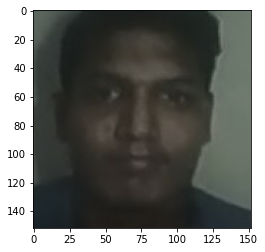


is it correct??
Enter yes or no
yes


In [6]:
cap = cv2.VideoCapture(1)
Gender = None
Birth = None
flag = None
Adhaar_Number = None
face = None
Name = None
while True:
    ret,frame = cap.read()
    
    for i in reader.readtext(frame):
        if i[2]>0.40 or ((i[1].replace(' ','')).isnumeric() and Adhaar_Number == None and len(i[1])==14):
            try:
                if ((i[1].replace(' ','')).isalpha() and Name == None and (i[1].replace(' ','')).lower() not in 'governmentofindia' and len(i[1]) > 7) :
                    frame = cv2.rectangle(frame,tuple(i[0][0]),(i[0][0][0]+250,i[0][0][1]+170),(0,255,0),3)
                    Name = i[1]
                    
            except:
                pass
            if ((i[1].replace('/',''))).isnumeric() and Birth == None and len(i[1])>= 4 and int((i[1].replace('/',''))[-4:]) < 2019 and len(i[1].replace('/','')) <=8  :
                Birth = i[1]

                
            if ((i[1]=='Male' or i[1] == 'Female') and Gender == None) :
                Gender = i[1]    
                
                
            if ((i[1].replace(' ','')).isnumeric() and Adhaar_Number == None and len(i[1])>=12):
                Adhaar_Number = i[1]
                
            if face is None:
                face = face_extractor(frame)
            
            
            if (Name != None and Gender != None and Birth != None and Adhaar_Number != None and face is not None ):
                print(f'Name : {Name}')
                print(f'Birth : {Birth}')
                print(f'Gender : {Gender}')
                print(f'Adhaar_Number : {Adhaar_Number}')
                plt.imshow(face[:,:,::-1])
                plt.show()
                print()
                print('is it correct??')
                print('Enter yes or no')
                ans = input()
                if ans == 'yes':
                    flag = 0
                    break
                else:
                    Name = None
                    Birth = None
                    Gender = None
                    face = None
                    Adhaar_Number = None
    
    cv2.imshow('web',frame)

    if cv2.waitKey(1) == 13 or flag==0:  
        break
cap.release()
cv2.destroyAllWindows()
